# HT 7. Tensorflow2

**MINERÍA DE DATOS - SECCIÓN - 20 - 2024 - 1**

Samuel Chamalé, 21881

Renatto Guzmán, 21646

---


In [3]:
# Importando las librerías necesarias para las simulaciones
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
%matplotlib inline

In [43]:
def simpleLinearRegression(observaciones=1000, learning_rate=0.02, epochs=100, loss='mean_squared_error'):
    # Definición de las variables y el modelo según el código proporcionado en el ejemplo
    # Generando datos aleatorios para x1 y x2
    x1 = np.random.uniform(low=-10, high=10, size=(observaciones, 1))
    x2 = np.random.uniform(-10, 10, (observaciones, 1))
    X = np.column_stack((x1, x2))

    ruido = np.random.uniform(-1, 1, (observaciones, 1))

    y = 2 * x1 - 3 * x2 + 5 + ruido

    np.savez('DatosRegression', inputs=X, targets=y)
    datos = np.load('DatosRegression.npz')

    tamanio_entrada = 2
    tamanio_salida = 1

    modelo = tf.keras.Sequential([
        tf.keras.layers.Dense(
            tamanio_salida,
            kernel_initializer=tf.random_uniform_initializer(
                minval=-0.1, maxval=0.1),
            bias_initializer=tf.random_uniform_initializer(
                minval=-0.1, maxval=0.1)
        )
    ])

    optimizador_adhoc = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    modelo.compile(optimizer=optimizador_adhoc, loss=loss)

    modelo.fit(datos['inputs'], datos['targets'], epochs=epochs, verbose=0)

    pesos = modelo.layers[0].get_weights()[0]
    sesgos = modelo.layers[0].get_weights()[1]

    plt.figure(figsize=(10, 10))
    plt.plot(np.squeeze(modelo.predict_on_batch(datos['inputs'])),
             np.squeeze(datos['targets']), color='red')
    plt.suptitle('Predicciones vs Metas Reales', fontsize=20)
    plt.title(
        f"[observaciones={observaciones}, learning_rate={learning_rate}, epochs={epochs}, loss={loss}] [pesos={np.squeeze(pesos)} sesgos={np.squeeze(sesgos)}]"
    )

    plt.xlabel('Prediciones')
    plt.ylabel('Metas Reales')
    plt.show()

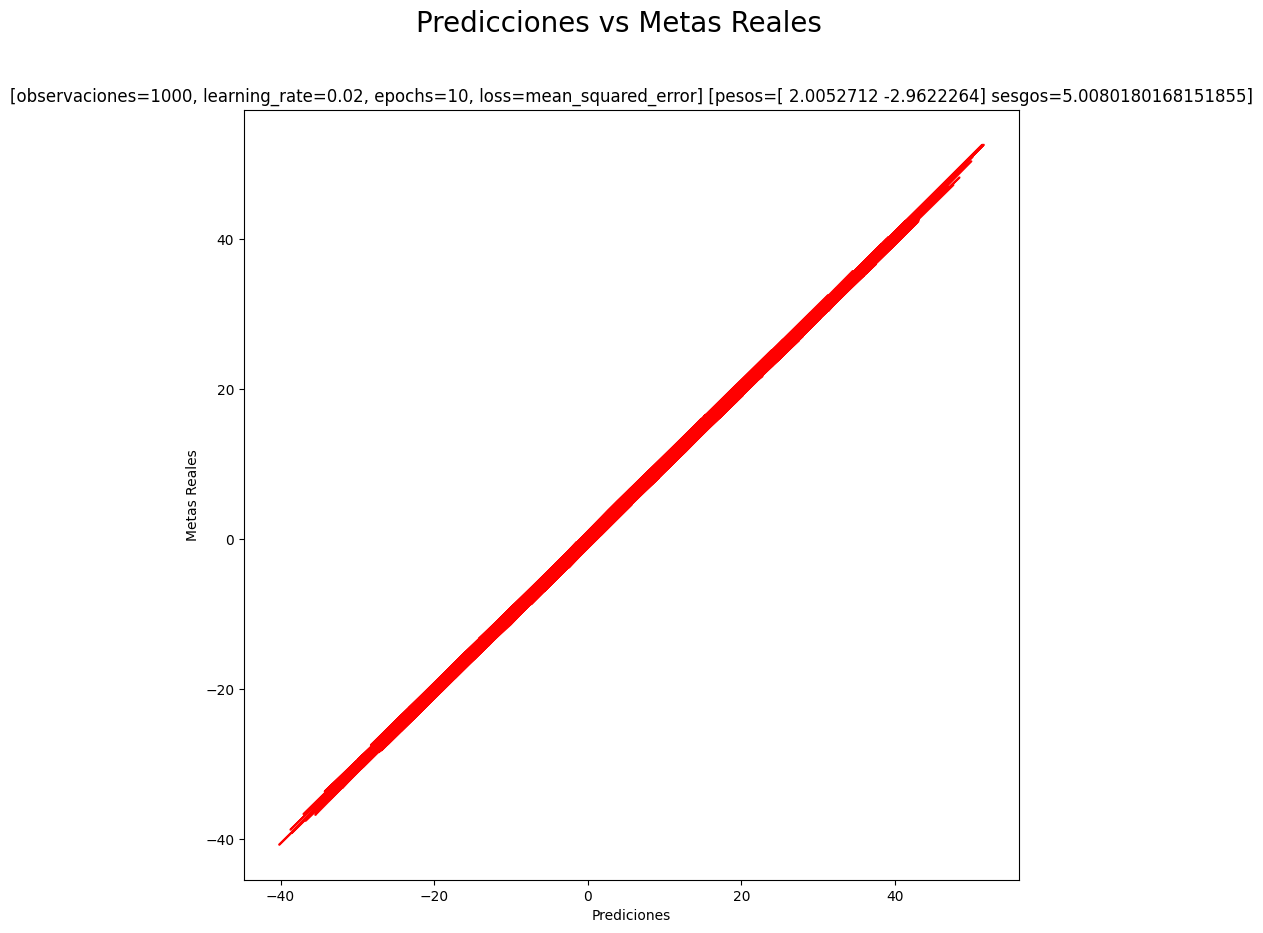

In [44]:
simpleLinearRegression(observaciones=1000, learning_rate=0.02,
                       epochs=10, loss='mean_squared_error')